Installing needed libraries.

In [1]:
%pip install numpy

In [2]:
%pip install scipy

In [3]:
%pip install pandas

In [4]:
%pip install scikit-learn

In [5]:
%pip install matplotlib

In [6]:
%pip install ipywidgets

Now importing the libararies we'll use and setting up the DataFrame variables.

In [7]:
import csv
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [10]:
# reading in a csv with the game IDs and corresponding names.
myfile = open('ID_and_name.csv')
csvreader = csv.reader(myfile, delimiter=',')

id_name_list = list(csvreader)
myfile.close()
id_name_dict = {}

# putting the data from the csv list into a dictionary.
for row in id_name_list:
    id_name_dict[int(row[0])] = row[1]

In [11]:
# reading in csv with all the video game data that will be used in the algorithm
game_data = pd.read_csv('category_and_genre.csv', index_col='appid')
# creating copies of the pandas DataFrame so we can manipulate them without altering the original.
game_data_cluster_selection = game_data.copy()
game_data_labeled = game_data.copy()

Below is code obtained from scikit-learn's example of using silhouette method to find a good cluster amount to use for KMeans clustering.
It is commented out because it causes an error on Jupyter Notebooks due to using too much memory.

Due to the nature and uneven distribution of my data the elbow method didn't have a clear result, and neither did the silhouette method.
There were many amounts of clusters that appeared like that would work, and since the specific amount of clusters won't have much of an impact on
my system's performance I chose a somewhat arbitrary number of 46 clusters.

In [12]:
# code is from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html and then was modified for my needs.

#for n_clusters in range(2, 51):
#    # Create a subplot with 1 row and 2 columns
#    fig, (ax1) = plt.subplots(1, 1)
#    fig.set_size_inches(18, 7)
#
#    # The 1st subplot is the silhouette plot
#    # The silhouette coefficient can range from -1, 1 but in this example all
#    # lie within [-0.1, 1]
#    ax1.set_xlim([-0.1, 1])
#    # The (n_clusters+1)*10 is for inserting blank space between silhouette
#    # plots of individual clusters, to demarcate them clearly.
#    ax1.set_ylim([0, len(game_data_cluster_selection) + (n_clusters + 1) * 10])
#
#    # Initialize the clusterer with n_clusters value and a random generator
#    # seed of 10 for reproducibility.
#    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
#    cluster_labels = clusterer.fit_predict(game_data_cluster_selection)
#
#    # The silhouette_score gives the average value for all the samples.
#    # This gives a perspective into the density and separation of the formed
#    # clusters
#    silhouette_avg = silhouette_score(game_data_cluster_selection, cluster_labels)
#    print(
#        "For n_clusters =",
#        n_clusters,
#        "The average silhouette_score is :",
#        silhouette_avg,
#    )
#
#    # Compute the silhouette scores for each sample
#    sample_silhouette_values = silhouette_samples(game_data_cluster_selection, cluster_labels)
#
#    y_lower = 10
#    for i in range(n_clusters):
#        # Aggregate the silhouette scores for samples belonging to
#        # cluster i, and sort them
#        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#
#        ith_cluster_silhouette_values.sort()
#
#        size_cluster_i = ith_cluster_silhouette_values.shape[0]
#        y_upper = y_lower + size_cluster_i
#
#        ax1.fill_betweenx(
#            np.arange(y_lower, y_upper),
#            0,
#            ith_cluster_silhouette_values,
#            alpha=0.7,
#        )
#
#        # Label the silhouette plots with their cluster numbers at the middle
#        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#
#        # Compute the new y_lower for next plot
#        y_lower = y_upper + 10  # 10 for the 0 samples
#
#    ax1.set_title("The silhouette plot for the various clusters.")
#    ax1.set_xlabel("The silhouette coefficient values")
#    ax1.set_ylabel("Cluster label")
#
#    # The vertical line for average silhouette score of all the values
#    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
#
#    ax1.set_yticks([])  # Clear the yaxis labels / ticks
#    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
#
#    plt.suptitle(
#        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#        % n_clusters,
#        fontsize=14,
#        fontweight="bold",
#    )
#
#plt.show()


In [13]:
# Initializing the KMeans algorithm we'll use with 46 clusters.
kmeans = KMeans(n_clusters=46, n_init='auto', random_state=0)

cluster_labels = kmeans.fit_predict(game_data)
# Applying the cluster labels and the video game name to one of our copied data lists.
game_data_labeled['Cluster'] = cluster_labels
game_data_labeled['Game_Name'] = id_name_dict.values()

In [14]:
# finds the 'n' most similar games to the given game
# name = the name of the game to find similar games to
# n_games = the number of games to be listed | Default = 10
# iteration = the number of times the function has looped. Should not be changed. In place to prevent infinite loops | Default = 1
# RETURNS = a list of the names of 'n' similar games
def find_n_nearest_games(name, n_games=10, iteration=1):
    # getting the 0-based index of the selected game.
    dataframe_index = np.where(game_data_labeled['Game_Name'] == name)[0]
    # inverting the array so the euclidean distance between chosen game and all other points can be calculated.
    distances = pairwise_distances(np.reshape(game_data.iloc[dataframe_index], (1, -1)), game_data, metric='euclidean')
    # getting the index list for the 'n' closest games.
    index = [np.argpartition(i, n_games)[:n_games] for i in distances]
    # a small DataFrame is created based on the rows at each index for the most similar games.
    closest = [game_data.iloc[i] for i in index]
    closest_df = closest[0].copy()
    
    # iterating through the closest game list to print just the name of the similar games, excluding the chosen game.
    i = 1
    games = []
    for item in closest_df.index:
        if item != game_data.index[dataframe_index]:
            # calculates what percent of the genre/category tags are shared between the chosen game and the similar games
            chosen_game_tags = np.where(game_data.loc[game_data.index[dataframe_index]] == 1)[1]
            comparison_game_tags = np.where(game_data.loc[item] == 1)
            shared_tags = np.intersect1d(chosen_game_tags, comparison_game_tags)
            all_unique_tags = np.union1d(chosen_game_tags, comparison_game_tags)
            percent = len(shared_tags) / len(all_unique_tags)
            percent_str = '{:.0%}'.format(percent)

            games.append(str(i) + '. ' + game_data_labeled.loc[item, 'Game_Name'] + ' - - - - - similarity score: ' + percent_str)
            i = i + 1
    # if the returned list is shorter than the requested amount (usually due to removing the original game) then the funciton runs again with n_games being 1 higher.
    # uses iteration variable to prevent infinite loop.
    if iteration == 1:
        if len(games) < n_games:
            games = find_n_nearest_games(name, n_games+1, 2)
    
    return games

In [15]:
#game_dropdown = widgets.Dropdown(
#    options=list(id_name_dict.values()),
#    description='Select a game:',
#    disabled=False
#    index=1
#)
game_combobox = widgets.Combobox(
    placeholder='Select a game',
    options=list(id_name_dict.values()),
    ensure_option=True,
    disabled=False,
    index=0
)
amount_intslider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Select the amount of games to recommend:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
amount_boundedinttext = widgets.BoundedIntText(
    value=10,
    min=1,
    max=50,
    step=1,
    disabled=False
)
find_games_button = widgets.Button(
    description='Find some games!',
    disabled=False,
    button_style='info',
    tooltip='Press to see recommended games.',
    icon='gamepad'
)
output = widgets.Output()

def on_button_clicked(b):
    output.clear_output()
    game = game_combobox.value
    amount = amount_boundedinttext.value
    game_list = find_n_nearest_games(name=game, n_games=amount)
    with output:
        print(*game_list, sep='\n')
        
find_games_button.on_click(on_button_clicked)

#game_link = widgets.jslink((game_dropdown, 'value'), (game_combobox, 'value'))
#amount_link = widgets.jslink((amount_intslider, 'value'), (amount_boundedinttext, 'value'))
game_hbox = widgets.HBox([widgets.Label(value='Select a game:'), game_combobox])
amount_hbox = widgets.HBox([widgets.Label(value='Select the amount of games to recommend:'), amount_boundedinttext])

Below you can find a drop-down box that is also searchable. You can use it to select the game you want to find recommendations based off of. Below is a number box where you can input the amount of recommendations you want (maximum of 50). After, you just click the "Find some games!" button and the recommendations will pop up, with a percentage displaying what percent of the assigned genres and categories match your chosen game.

In [16]:
display(game_hbox)
display(amount_hbox)
display(find_games_button)
display(output)

Button(button_style='info', description='Find some games!', icon='gamepad', style=ButtonStyle(), tooltip='Pres…

Output()

In [17]:
category_amounts = {} 
# looping through all the categories and games and creating a dictionary with the key being a genre and the value being how many games have that genre tag.
for col in game_data.columns:
    if col not in category_amounts:
        category_amounts[col] = 0
    for index in game_data.index:
        inc = game_data.loc[index, col] + category_amounts[col]
        category_amounts[col] = inc

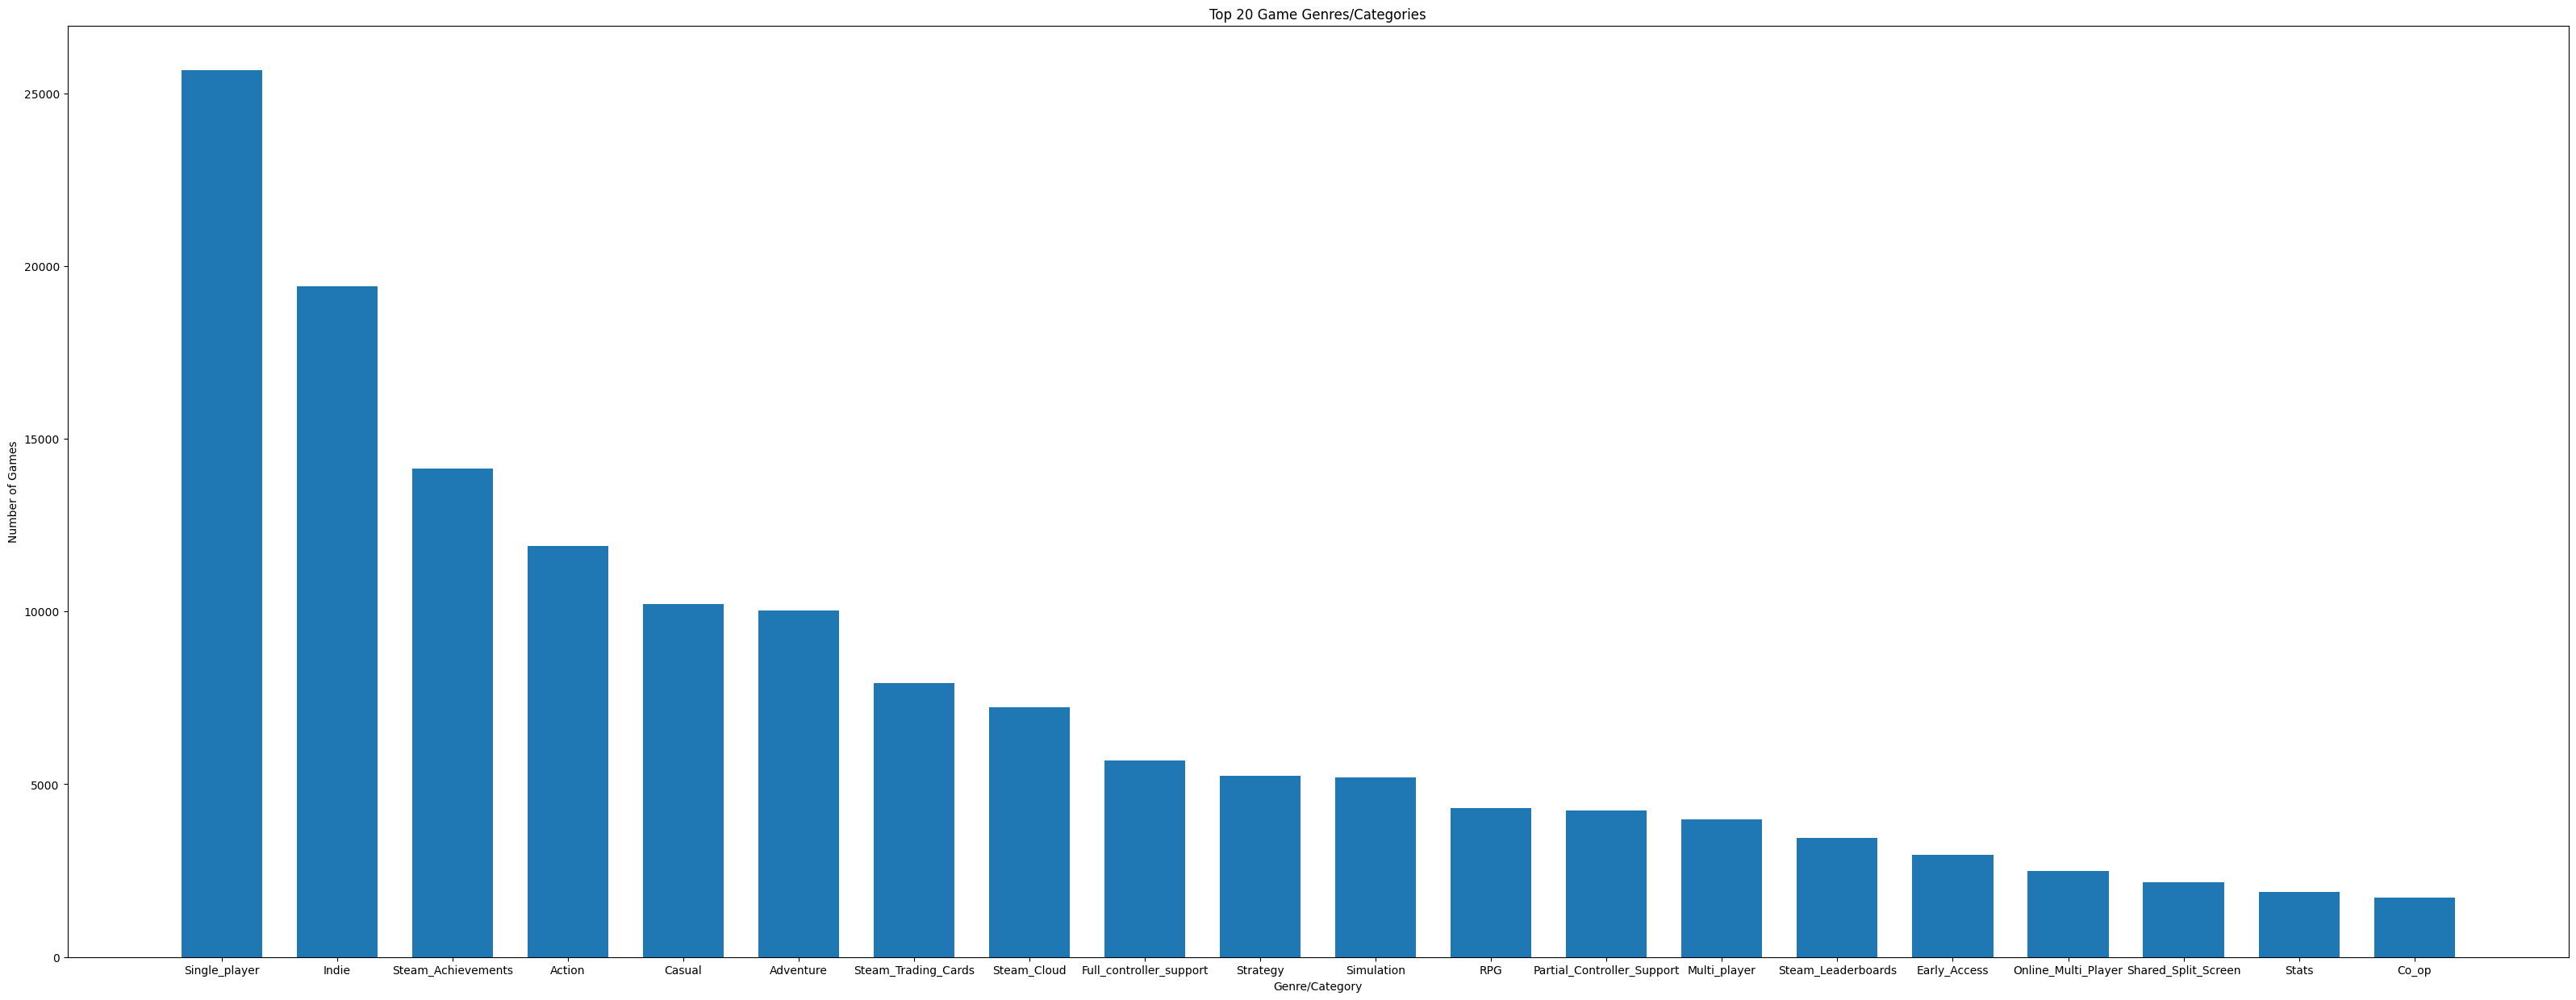

In [27]:
# splitting the dictionary into 2 lists, one with the Keys (Categories) and one with the values (frequency of category)
cat_list = list(category_amounts.keys())
cat_amount_list = list(category_amounts.values())
    
# Sorting the list by frequency and taking the top N genres
limit = 20
sorted_index_list = np.argsort(cat_amount_list)[-limit:]
sorted_x_list = []
sorted_y_list = []

# Using the index array to append the correct Category and Amounts to a list to be used for the bar graph.
for i in sorted_index_list:
    sorted_x_list.append(cat_list[i])
    sorted_y_list.append(cat_amount_list[i])

# Reversing the list so it is in Descending order
sorted_x_list.reverse()
sorted_y_list.reverse()

# Creatings and labeling the bar graph
fig = plt.figure(figsize = (40, 15))

plt.bar(sorted_x_list, sorted_y_list, width=0.7)
plt.xlabel('Genre/Category')
plt.ylabel('Number of Games')
plt.title('Top ' + str(limit) + ' Game Genres/Categories')
plt.show()


Above you can see that Single Player games are the most common kind, and there's a huge amount of indie games as well. Looking at the most common genres can help you see which labels will and will not help give a more specific and refined search. A single player, aciton, adventure game is going to have a lot more very similar games, compared to some of the labels not in the top 20, like a 2D platformer or a JRPG. 

Being able to accurately implement more specific tags and other things to categorize games by, such as the developer and/or publisher, would help the system be able to recommend games that are much more similar to the given game.

If you want to see more than the top 20, you can change what the variable *limit* is equal to, but it may make the graph very difficult to read if there's too many bars.

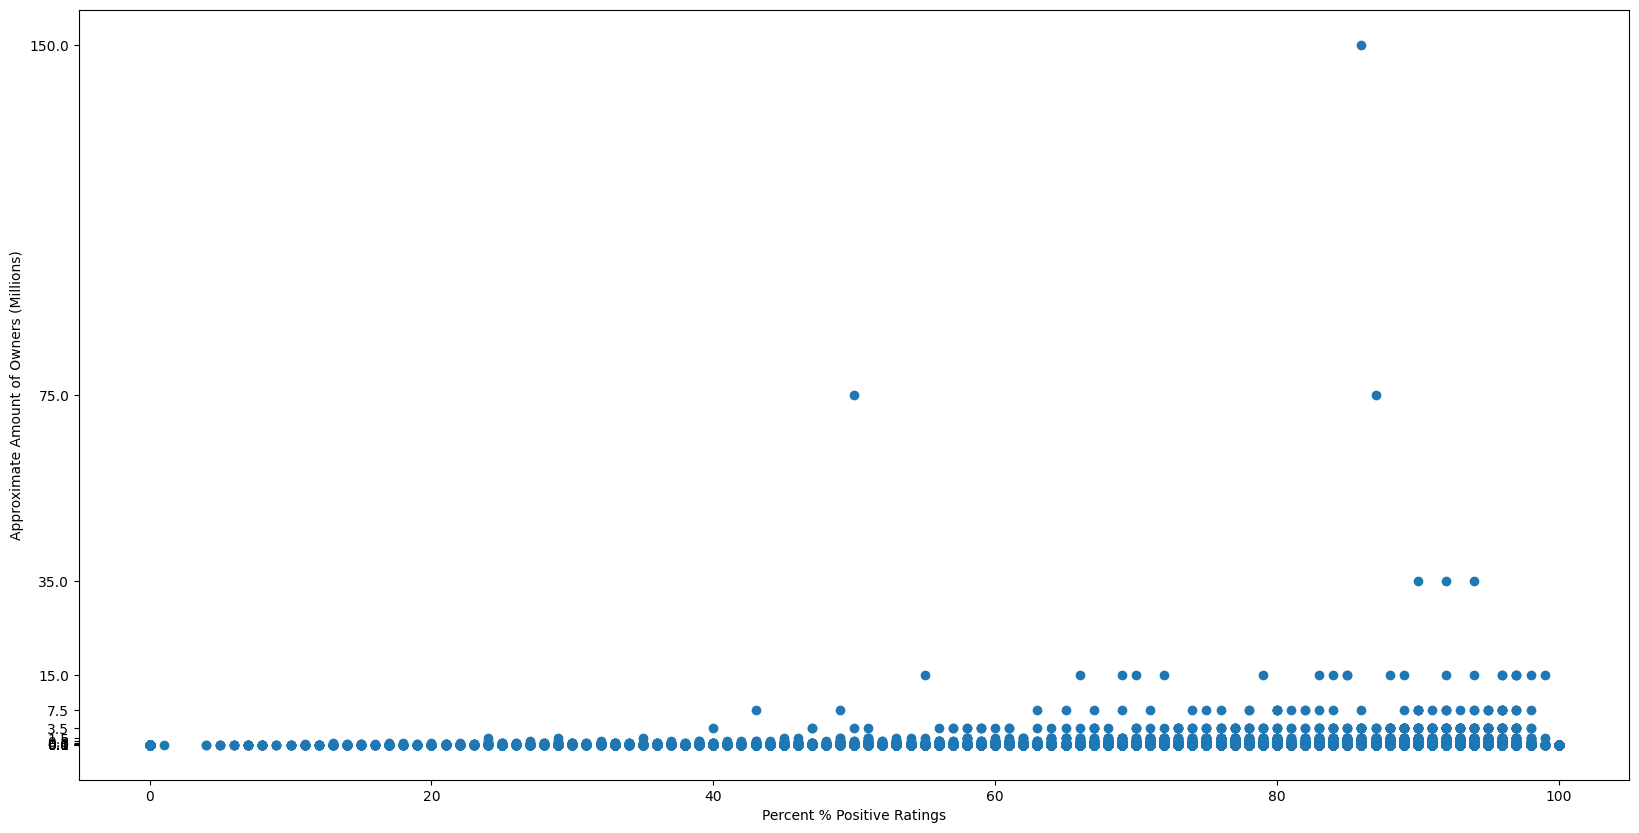

In [19]:
ratingsfile = open('rating_percent_owners.csv')
csvreader = csv.reader(ratingsfile, delimiter=',')
# opening and reading in the CSV file with information on positive rating percent and the amount of owners of each game.
id_ratings_owner_list = list(csvreader)
del id_ratings_owner_list[0]
ratingsfile.close()
ratings_list = []
owners_list_1 = []
# going through the list and separating the rating percentages and owner amounts into 2 separate lists so they can be used for a scatterplot graph
for row in id_ratings_owner_list:
    ratings_list.append(float(row[1])*100)
    owners_list_1.append(int(row[2])/1000000)

y_ticks = set(owners_list_1)
y_ticks_list = np.sort(list(y_ticks))
fig = plt.figure(figsize = (20, 10)) 

plt.yticks(y_ticks_list)
plt.scatter(ratings_list, owners_list_1)
plt.xlabel('Percent % Positive Ratings')
plt.ylabel('Approximate Amount of Owners (Millions)')
plt.show()

The data for this graph and the following 2 are comparisons of different metrics measured against the approximate amount of owners of the game purchased through the storefront. In the data I used the owner amounts were in large ranges, such as 1,000,000-2,000,000, so for the sake of making it easier to plot on a graph I took the average of the given range and used that. That is the cause of all the exact matches plotted on the graph.

In this graph I show a scatterplot of what percent of reviews for the game are positive and compare that to the amount of people who own the game. I wanted to see if more popular games had more high ratings. There seems to be a slightly positive correlation, but personally I don't think it's strong enough to warrant any sort of implementation, except for maybe just a filter to exclude games with a really low rating score to not show up on recommendation lists at all. Otherwise there's going to be niche games that don't appeal to the masses, but could be a well made game for a small crowd, so it would have a high rating percentage without having a huge playerbase.

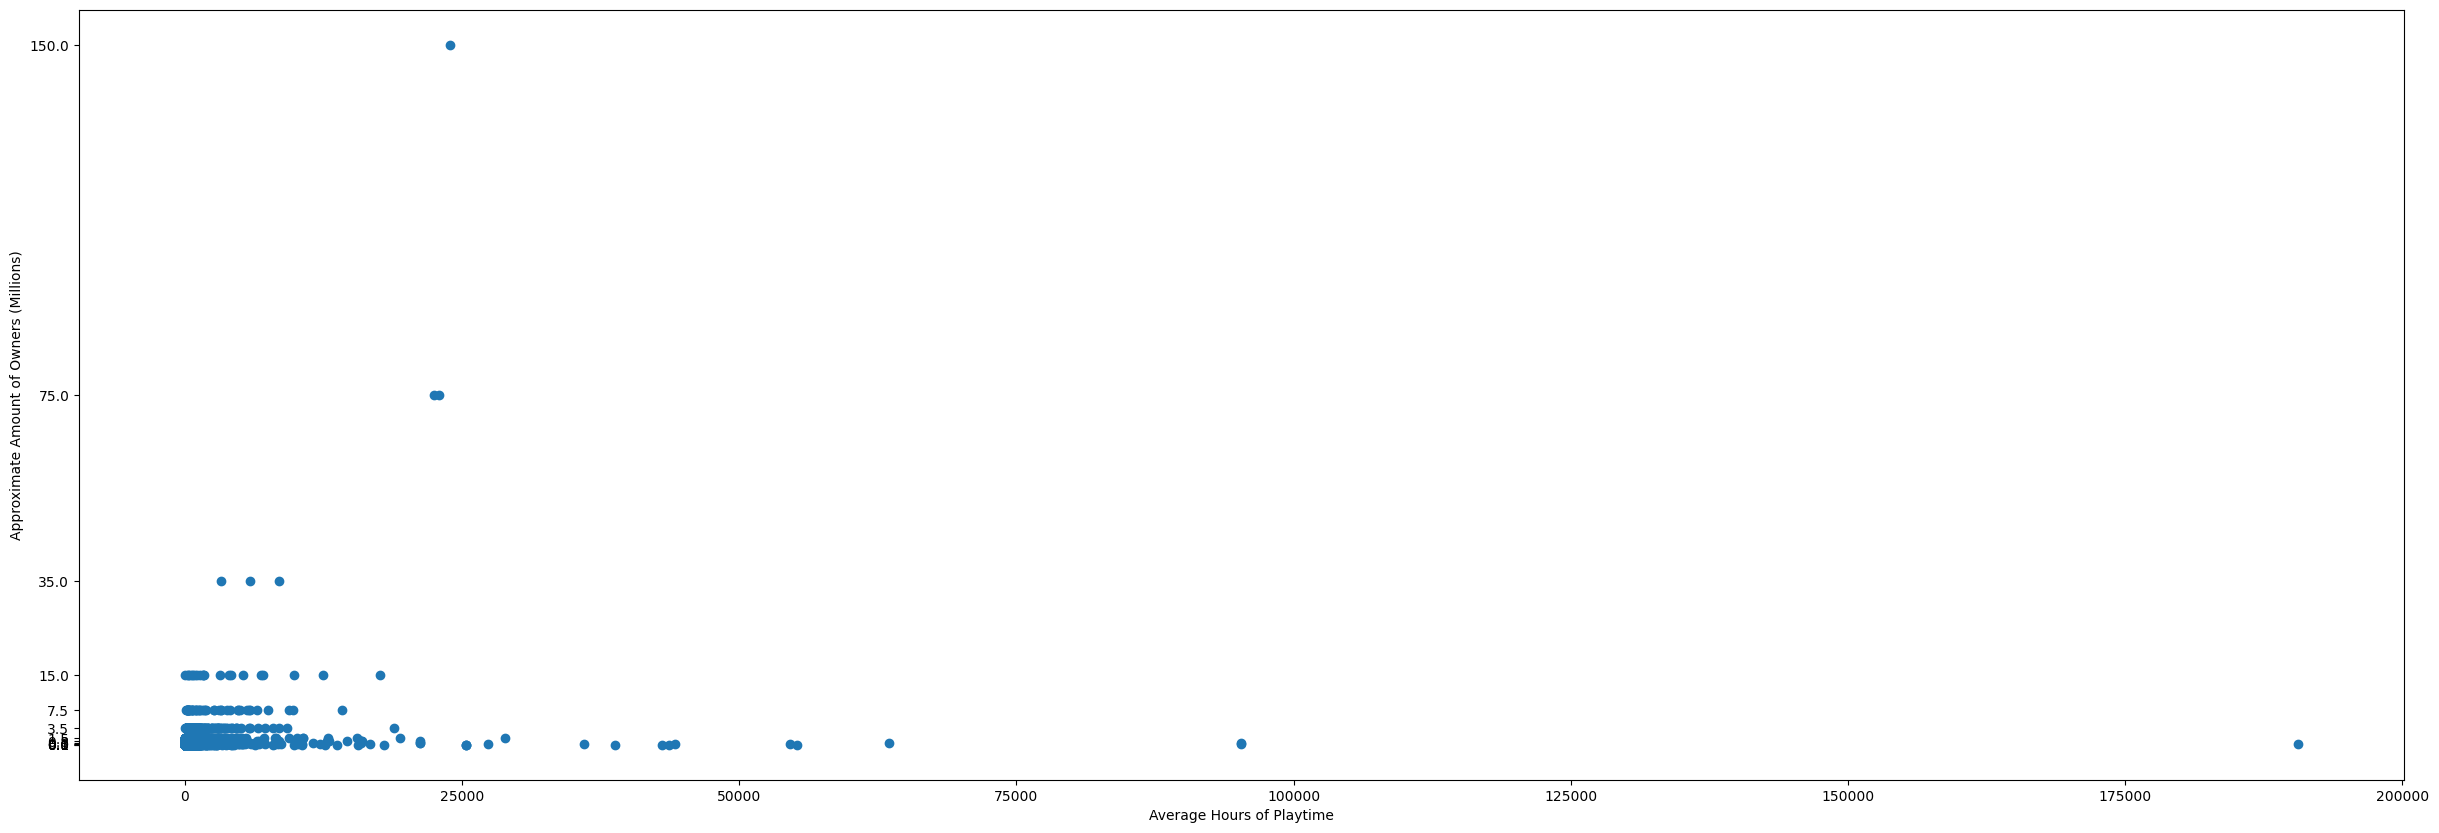

In [20]:
playtimefile = open('avg_playtime_owners.csv')
csvreader = csv.reader(playtimefile, delimiter=',')
# opening and reading in the CSV file with information on average playtime and the amount of owners of games that had that data.
id_playtime_owner_list = list(csvreader)
del id_playtime_owner_list[0]
playtimefile.close()
playtime_list = []
owners_list_2 = []
# separating the average playtime and amount of owners into 2 separate lists so they can be used for a scatterplot graph
for row in id_playtime_owner_list:
    playtime_list.append(int(row[1]))
    owners_list_2.append(int(row[2])/1000000)

fig = plt.figure(figsize = (30, 10)) 

y_ticks2 = set(owners_list_2)
y_ticks_list2 = np.sort(list(y_ticks2))

plt.yticks(y_ticks_list2)
plt.scatter(playtime_list, owners_list_2)
plt.xlabel('Average Hours of Playtime')
plt.ylabel('Approximate Amount of Owners (Millions)')
plt.show()

This graph shows the average amount of playtime a game has versus the amount of owners. This was done to see if there was a correlation between how popular a game is and how long someone spends playing that game on average. Seeing these results there's not much that can be told. In retrospect it makes sense as some games are meant to be played continually, such as MMOs (Massively Multiplayer Online games) or competitive multiplayer games that have frequent and continual updates. In contrast there are many single player story games that aren't intended to be played over and over, and exist just to tell a story or share something with the player. There are also some extreme outliers that can be seen, and I'm not sure if the cause is botting in a game which could result in inhuman playtimes, or potentially typos or errors in data collection. Since I wasn't the one who gathered the data initially, I am not sure what the cause would be.

To make a more accurate graph that could result in more useful data there would need to be more precise genre and category tags, so single playthrough games could be filtered separately from online multiplayer games meant to be played continually. The outliers would also need to be removed to give a more real representation of the data.

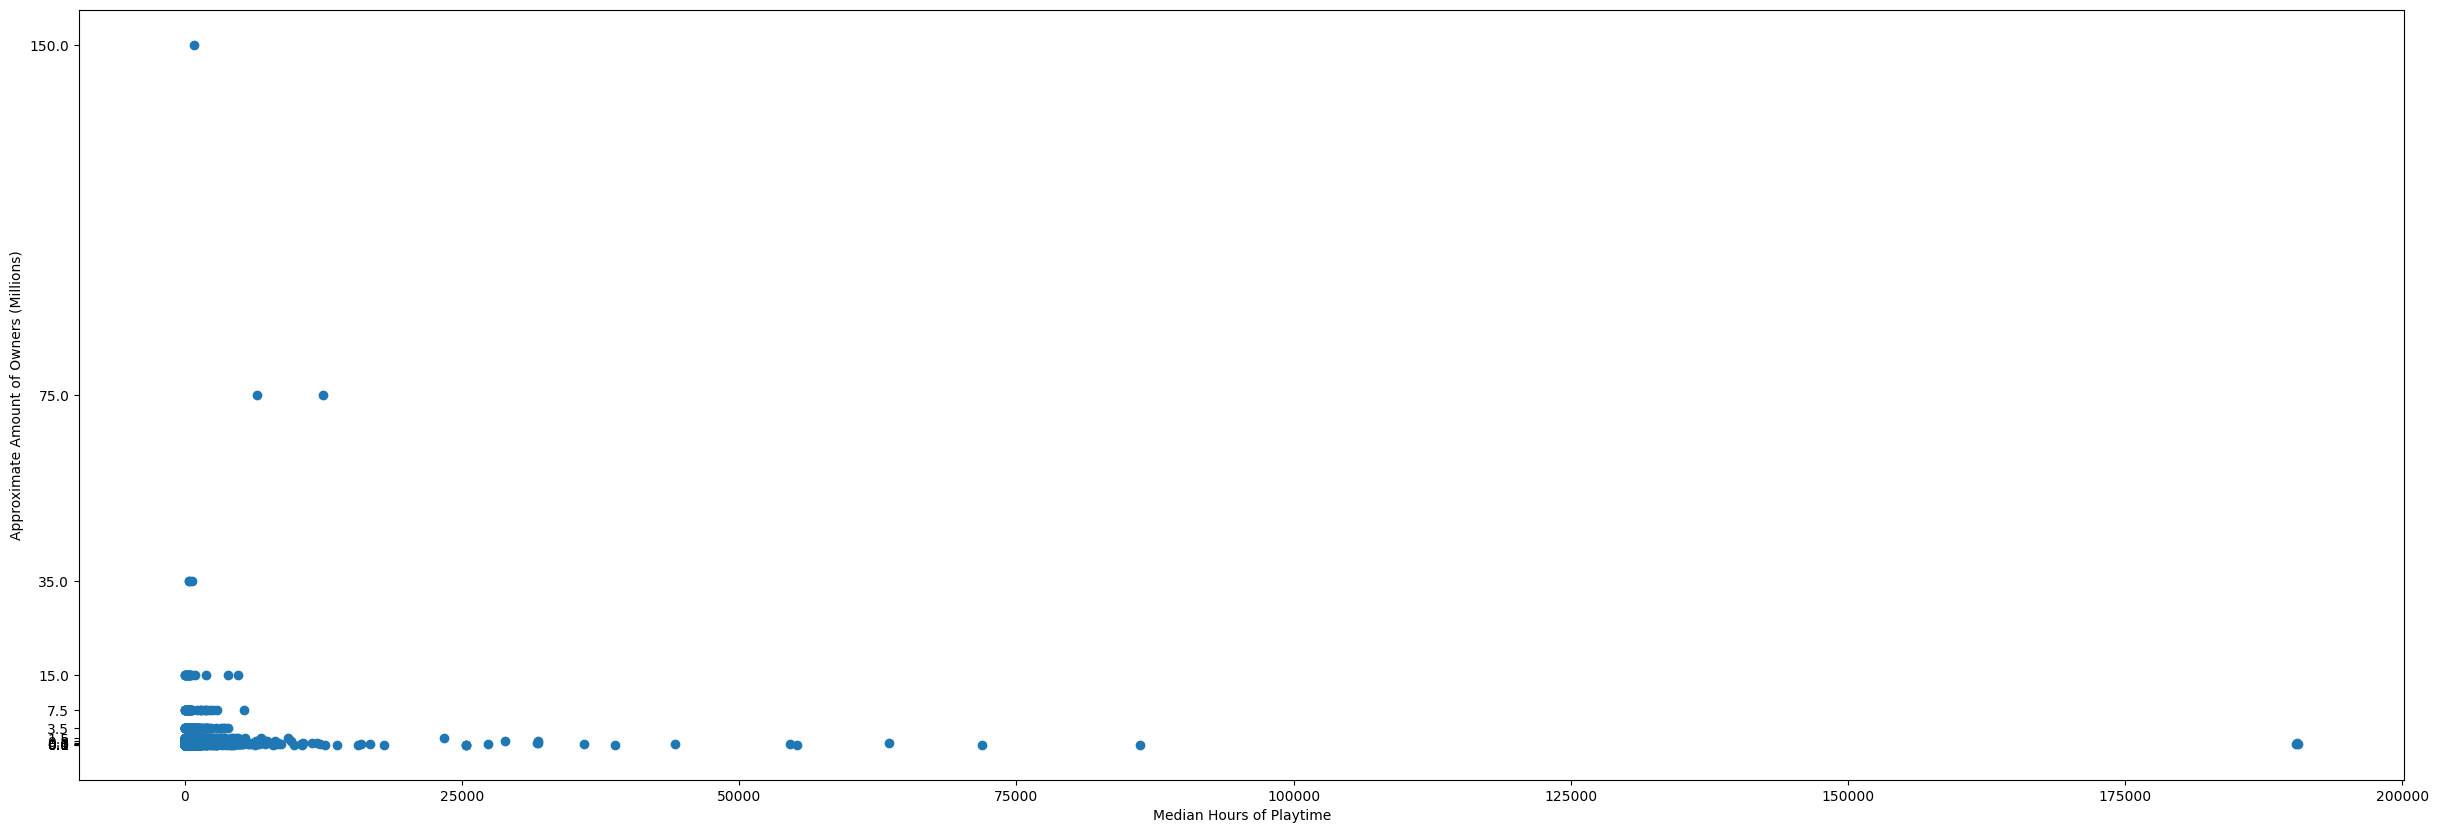

In [25]:
medianfile = open('median_playtime.csv')
csvreader = csv.reader(medianfile, delimiter = ',')

median_playtime_list = list(csvreader)

del median_playtime_list[0]
medianfile.close()

fig = plt.figure(figsize = (30, 10)) 

plt.yticks(y_ticks_list2)
plt.scatter(median_playtime_list, owners_list_2)
plt.xlabel('Median Hours of Playtime')
plt.ylabel('Approximate Amount of Owners (Millions)')
plt.show()

This graph is similar to the one above, but shows median playtime instead of average. As expected for most the games, the median is lower than the average and I think it shows that many people buy a game and try it out and maybe don't like it, or play a small amount and move on, but a smaller, dedicated playerbase will spend much more time on a game and that can skew the average up. Many of the outliers appear and aren't even very different from the average, so that does make me question the accuracy of the playtime data or if it is representing only real players and not a botting program.